<a href="https://colab.research.google.com/github/evanphoward/cs242-final/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering as HAC
import matplotlib.cm as cm
from cycler import cycler
import pandas as pd
import requests
import io

plt.rcParams.update({'font.size':16})

In [ ]:
#read in data from github
def remote_get(url):
  ro = requests.get(url) 
  if ro.ok:
    data = np.load(io.BytesIO(ro.content))
    return data 
  else:
    print('failed to retrive file')
    
  
#Data = remote_get('https://github.com/evanphoward/cs242-final/blob/main/cifar_input_values.npy?raw=true')  #set of data vectors (inputs to FC layer)
#b = remote_get('https://github.com/evanphoward/cs242-final/blob/main/cifar_classifier_weights.npy?raw=true') #weights of FC layer

#Data = np.load('cifar_input_values.npy')
#b = np.load('cifar_classifier_weights.npy')

#for k in Data.keys():
#  print(k)
#for l in b.keys():
#  print(k)

In [ ]:

### only needed if you need to make fake data 
#make set of fake data
def make_data():
  ndim = 21
  n_centers = 15
  n_samples = 1000
  bxsz = 30

  MU = []
  mu = (np.random.rand(ndim) - 0.5*np.ones((ndim))) * bxsz
  temp  = np.random.rand(ndim,ndim)
  e_val, e_vec = np.linalg.eig(temp.T @ temp)
  cov = e_vec @ np.diag(np.abs(np.random.randn(ndim)*4)) @ e_vec.T
  Data = np.random.multivariate_normal(mu, cov, size=n_samples).T
  MU.append(mu)
  for mu in range(n_centers-1):
      mu = (np.random.rand(ndim) - 0.5*np.ones((ndim))) * bxsz
      temp  = np.random.rand(ndim,ndim)
      e_val, e_vec = np.linalg.eig(temp.T @ temp)
      cov = e_vec @ np.diag(np.abs(np.random.randn(ndim)*4)) @ e_vec.T
      Data = np.concatenate((Data, np.random.multivariate_normal(mu, cov, size=n_samples).T), axis=1)
      MU.append(mu)

  MU = np.array(MU)

  #make fake weight values
  b = np.random.randn(ndim,1)
  return Data, b

Data, b = make_data()

In [ ]:
# calculate the centroids using clustering (but where this is done in each subspace)
def get_centroids(Data,b,n_sub=5,n_cen=5):
  # Data: n_dim x n_samples matrix of vectors
  # b : n_dim x n_weights matrix of fixed weights
  # n_sub:  number of subspaces
  # n_cen: number of centroids 
  n_dim = Data.shape[0]
  n_samples = Data.shape[1]
  n_weights = b.shape[1]
  Data_approx = np.zeros_like(Data)
  Centroids = []
  r = n_dim % n_sub

  subspace_idx_pairs = []
  i=0
  for idx in range(n_sub):
      irange = n_dim//n_sub + bool(idx<r)
      subspace_idx_pairs.append((i,i+irange))
      i = i+irange
      
  covariances = []
  Labels = []
  for i1,i2 in subspace_idx_pairs:
      kmeans = KMeans(n_clusters=n_cen).fit(Data[i1:i2,:].T)
      Centroids.append(kmeans.cluster_centers_.T)
      Labels.append(kmeans.labels_)
      
      #subspace_cov = []
      Data_approx[i1:i2,:] = kmeans.cluster_centers_.T[:,kmeans.labels_]
      #for label in np.unique(kmeans.labels_):
          #mask = kmeans.labels_ == label
          #X = Data[i1:i2,mask] - Data[i1:i2,mask].mean(axis=1).reshape(-1,1)
          #subspace_cov.append( X @ X.T /(np.sum(mask)-1))
      
      #covariances.append(subspace_cov)

  Labels = np.array(Labels)
  return Data_approx, Centroids, Labels, covariances, subspace_idx_pairs

#fast version of the above that just returns total mse
def get_error(Data, b, n_sub=5, n_cen=5):
  n_dim = Data.shape[0]
  Data_approx = np.zeros_like(Data)
  r = n_dim % n_sub

  i = 0
  for idx in range(n_sub):
      irange = n_dim//n_sub + bool(idx<r)
      kmeans = KMeans(n_clusters=n_cen).fit(Data[i:i+irange,:].T)
      Data_approx[i:i+irange,:] = kmeans.cluster_centers_.T[:,kmeans.labels_]
      i = i+irange

  return np.mean((Data_approx.T @ b - Data.T @ b)**2) #total mse

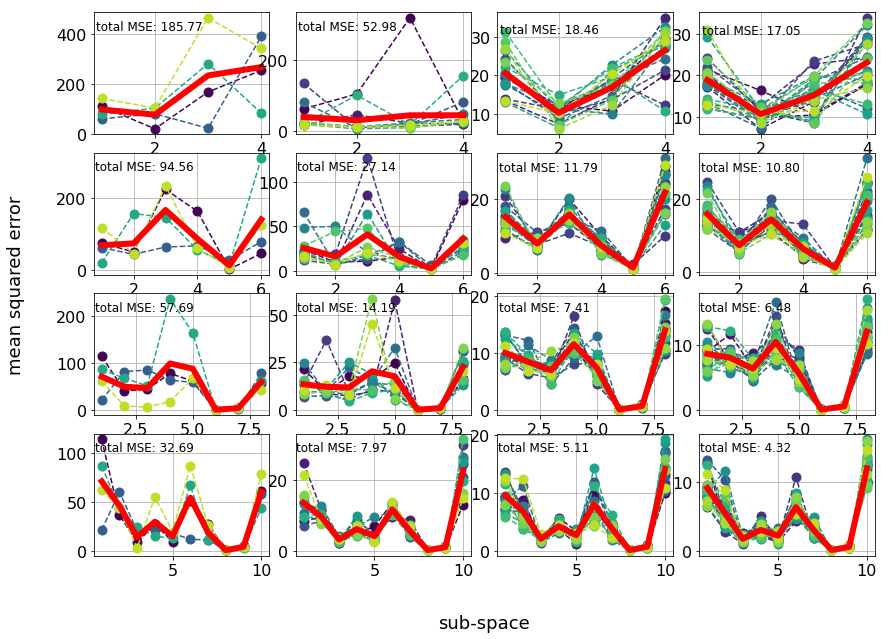

In [ ]:
# function to plot the MSEs in each subspace for each K-Means cluster
def plot_mse(ax,Error,Labels):
  n_sub = Error.shape[0]
  n_cen = len(np.unique(Labels[0,:]))
  cmap = cm.get_cmap('viridis')
  custom_cycler = cycler(color=cmap(np.linspace(0,0.9,n_cen))) 
  ax.set_prop_cycle(custom_cycler)

  error2 = np.zeros((n_sub,n_cen))
  for subspc in range(n_sub):
      for lbl in np.unique(Labels[subspc]):
          mask = Labels[subspc]==lbl
          error2[subspc,lbl] = np.mean(Error[subspc,mask]**2)
  
  total_mse = np.mean(Error**2)
  
  ax.plot(np.arange(1,n_sub+1), error2, '.--', ms=18)
  ax.plot(np.arange(1,n_sub+1), np.mean(error2,axis=1),'r',lw=6)
  #ax.set(xticks=np.arange(1,n_cen+1), xlabel='subspace' ,ylabel=r'mean squarred error')
  ax.text(ax.get_xlim()[0]+0.05, ax.get_ylim()[1]*0.85, 'total MSE: {:.2f}'.format(total_mse), fontsize=12)
  ax.grid()

  return total_mse


#try out different parameter values for n_sub and n_cen
n_samples = Data.shape[1]
sbspcs = 4
centrds = 4
fig,ax = plt.subplots(sbspcs, centrds, figsize=(14,10),gridspec_kw={'hspace':0.15,'wspace':0.15})
bigInvisibleAx = fig.add_subplot(111,frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
bigInvisibleAx.set_ylabel('mean squared error', fontsize=18, labelpad=36)
bigInvisibleAx.set_xlabel('sub-space', fontsize=18, labelpad=36)

for row, n_sub in enumerate(np.linspace(4,10,sbspcs,dtype=int)):
  for col, n_cen in enumerate(np.linspace(4,25,centrds,dtype=int)):
    Data_approx, Centroids, Labels, covariances, subspace_idx_pairs = get_centroids(Data, b, n_sub=n_sub, n_cen=n_cen)

    # calculate the error of the approximation compared to the real values  
    Error = np.zeros((n_sub,n_samples))
    for idx,(i1,i2) in enumerate(subspace_idx_pairs):
      Error[idx,:] = (Data_approx[i1:i2,:].T @ b[i1:i2,:] - Data[i1:i2,:].T @ b[i1:i2,:]).squeeze() 

    plot_mse(ax[row,col], Error, Labels)

In [ ]:
#now make a function which is much faster and just let's you make a contour plot of the MSE vs C and K 
sbspcs = np.linspace(4,18,8,dtype=int)
cntrds = np.linspace(2,32,16,dtype=int)
mse = np.zeros((len(cntrds), len(sbspcs)))
for row, n_cen in enumerate(cntrds):
  for col, n_sub in enumerate(sbspcs):
    mse[row,col] = get_error(Data, b, n_sub=n_sub, n_cen=n_cen)

<a list of 7 text.Text objects>

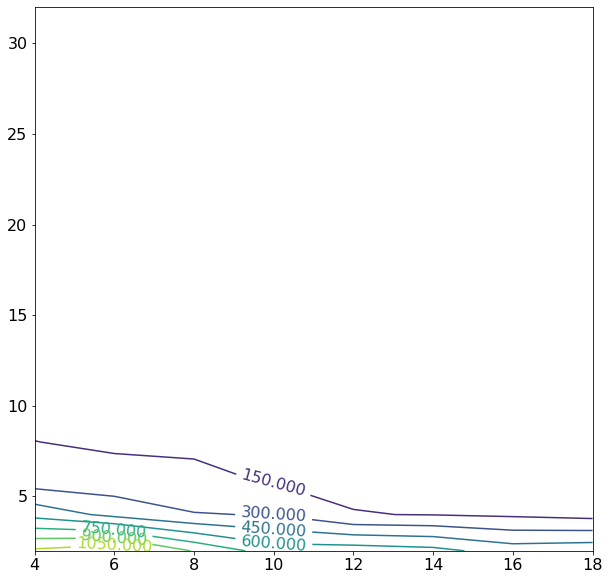

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,10))
X, Y = np.meshgrid(sbspcs, cntrds)
CS = ax.contour(X, Y, mse)
ax.clabel(CS, inline=True)